In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from msmbuilder.example_datasets import MetEnkephalin
metenkephalin = MetEnkephalin().get()
trajs = metenkephalin.trajectories

met_enkephalin already is cached


In [3]:
print(metenkephalin.DESCR)

The dataset consists of ten ~50 ns molecular dynamics (MD) simulation
trajectories of the 5 residue Met-enkaphalin peptide. The aggregate
sampling is 499.58 ns. Simulations were performed starting from the 1st
model in the 1PLX PDB file, solvated with 832 TIP3P water molecules using
OpenMM 6.0. The coordinates (protein only -- the water was stripped)
are saved every 5 picoseconds. Each of the ten trajectories is roughly
50 ns long and contains about 10,000 snapshots.

Forcefield: amber99sb-ildn; water: tip3p; nonbonded method: PME; cutoffs:
1nm; bonds to hydrogen were constrained; integrator: langevin dynamics;
temperature: 300K; friction coefficient: 1.0/ps; pressure control: Monte
Carlo barostat (interval of 25 steps); timestep 2 fs.

The dataset is available on figshare at

http://dx.doi.org/10.6084/m9.figshare.1026324



In [4]:
import mdtraj as md
traj = trajs[0]
traj.n_atoms

75

In [5]:
from msmbuilder.featurizer import AtomPairsFeaturizer

all_atoms = np.arange(traj.n_atoms)
pairs = []
for i in all_atoms:
    for j in all_atoms:
        if (i < j):
            pairs.append((i,j))
np.random.seed(0)
np.random.shuffle(pairs)
apf_feat = AtomPairsFeaturizer(pair_indices=pairs)

In [6]:
X = apf_feat.transform(trajs)
X[0].shape

(9992, 2775)

In [7]:
from msmbuilder.decomposition import tICA

tica = tICA(lag_time=10, n_components=100)
ys = tica.fit_transform(X)
tica.score_

74.7285312676285

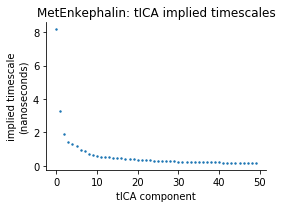

In [8]:
plt.figure(figsize=(4,3))
ax = plt.subplot(111)

n_processes = 50

plt.scatter(np.arange(len(tica.timescales_))[:n_processes], tica.timescales_[:n_processes] * 5 / 1000, s=2)
plt.xlabel('tICA component')
plt.ylabel('implied timescale\n(nanoseconds)')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title('MetEnkephalin: tICA implied timescales')

plt.tight_layout()
plt.savefig('implied-timescales.jpg', dpi=600, bbox_inches='tight')

In [9]:
blue = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]

In [10]:
xticks = [-1,0,1,2,3]
yticks = [-2,-1,0,1,2]
xlim = (np.vstack(ys)[:,0].min() * 1.1, np.vstack(ys)[:,0].max() * 1.1)
ylim = (np.vstack(ys)[:,1].min() * 1.1, np.vstack(ys)[:,1].max() * 1.1)
seperator = 1

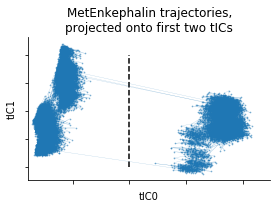

In [11]:
plt.figure(figsize=(4,3))
ax = plt.subplot(111)
for y in ys:
    plt.plot(y[:,0], y[:,1], linewidth=0.2, color=blue, alpha=0.5)
    plt.scatter(y[:,0], y[:,1], s=0.5, color=blue, alpha=0.5)

plt.xticks(xticks, [''] * len(xticks))
plt.yticks(yticks, [''] * len(yticks))
plt.vlines(seperator, min(yticks), max(yticks), linestyles='--')
plt.xlim(*xlim)
plt.ylim(*ylim)
plt.xlabel('tIC0')
plt.ylabel('tIC1')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title('MetEnkephalin trajectories,\nprojected onto first two tICs')
plt.tight_layout()
plt.savefig('tic0-vs-tic1-trajectories.jpg', dpi=600, bbox_inches='tight')

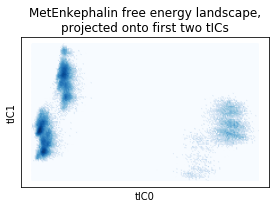

In [12]:
plt.figure(figsize=(4,3))
ax = plt.subplot(111)
ys = tica.transform(X)
plt.hexbin(np.vstack(ys)[:,0], np.vstack(ys)[:,1], cmap='Blues', bins='log', gridsize=200)
plt.xlabel('tIC0')
plt.ylabel('tIC1')
plt.xticks([])
plt.yticks([])
plt.title('MetEnkephalin free energy landscape,\nprojected onto first two tICs')
plt.tight_layout()
plt.savefig('tic0-vs-tic1-free-energy.jpg', dpi=600, bbox_inches='tight')

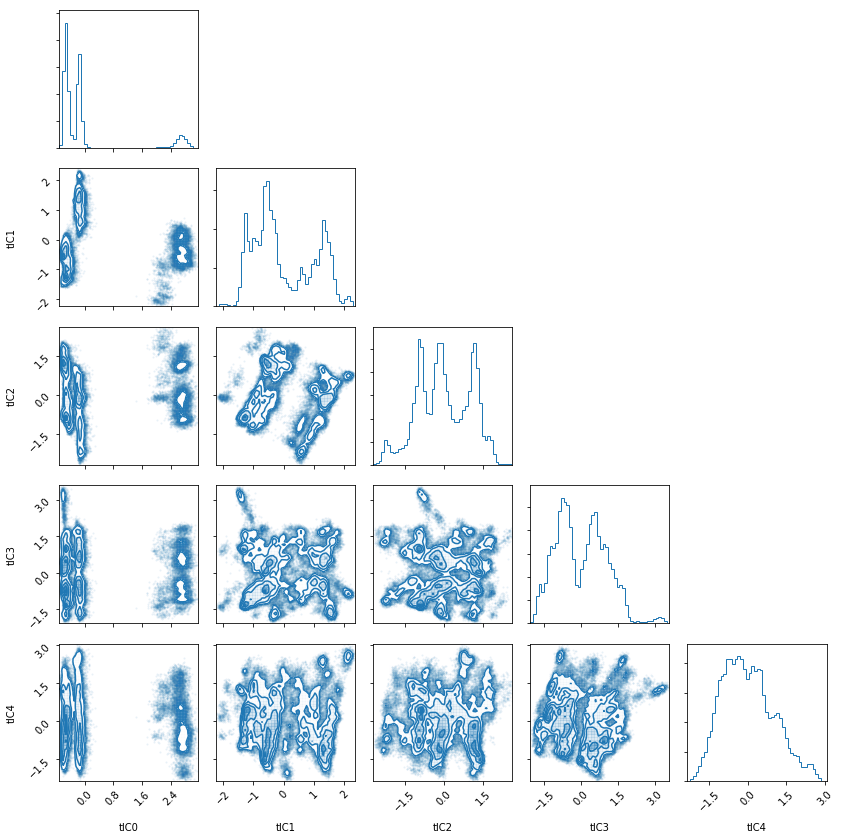

In [13]:
# let's look at projections on pairs of tICs 0 through 4
from corner import corner
_ = corner(np.vstack(ys)[:,:5],
           bins=50,
           color=blue,
           labels=['tIC{}'.format(i) for i in range(5)],
          )
plt.tight_layout()
plt.savefig('tics0-through-5.jpg', dpi=300, bbox_inches='tight')

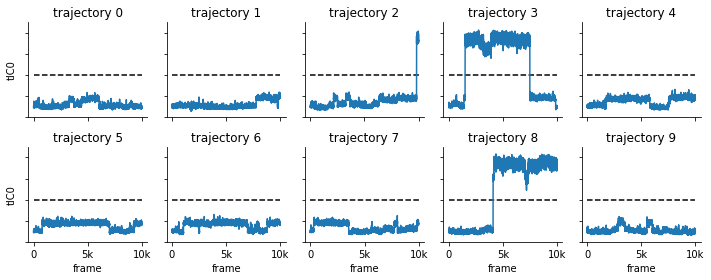

In [14]:
plt.figure(figsize=(5*2,2*2))
for i, y in enumerate(ys):

    ax = plt.subplot(2, 5, i + 1)
    
    plt.plot(y[:,0])            
    
    plt.ylim(*xlim)
    plt.hlines(seperator, 0, len(y), linestyles='--')
    
    plt.yticks(xticks, ['']*len(xticks))
    
    if i == 0 or i == 5:
        plt.ylabel('tIC0')
        plt.yticks(xticks)
    
    
    if i > 4:
        plt.xlabel('frame')
        plt.xticks([0,5000,10000], ['0', '5k', '10k'])
    else:
        plt.xticks([0,5000,10000], [''] * 3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.title('trajectory {}'.format(i))
    
plt.tight_layout()
plt.savefig('tic0.jpg', dpi=600)

In [15]:
# find some transition points, and extract the 5 frames before and after each

event = np.argmax(ys[3][:,0] > seperator)
print(event)
transition_event1 = trajs[3][event - 5: event + 5]

1506


In [16]:
event = np.argmax(ys[3][5000:,0] < seperator) + 5000
print(event)
transition_event2 = trajs[3][event - 5: event + 5]

7479


In [17]:
event = np.argmax(ys[8][:,0] > seperator)
print(event)
transition_event3 = trajs[8][event - 5: event + 5]

4090


In [18]:
# superpose them all, and then save them out

reference_frame = transition_event1[5]

## get the tyrosine residue
#tyr_residue = reference_frame.topology.residue(0)
#print(tyr_residue)
#atom_indices = []
#for a in list(tyr_residue.atoms):
#    atom_indices.append(a.index)
#print(atom_indices)
#atom_indices = np.array(atom_indices)
atom_indices = all_atoms

for i, short_traj in enumerate([transition_event1, transition_event2, transition_event3]):
    short_traj.superpose(reference_frame, atom_indices=atom_indices) 
    short_traj.save_pdb('metenkephalin-transition-event-{}.pdb'.format(i + 1))

In [19]:
# I then loaded these pdbs into my preferred viewer